# Spinach Defect Detection

This notebook trains a YOLOv8 model to detect spinach leaves, stems and common defects from images.
It uses transfer learning from pretrained weights so training is fast even on a laptop.

| # | Class | What it is |
|---|-------|------------|
| 0 | `spinach_leaf` | The main leaf blade |
| 1 | `stem` | The stalk/petiole |
| 2 | `GOOD` | Healthy leaf, no issues |
| 3 | `YELLOW` | Yellowing across edges or whole leaf |
| 4 | `HOLE` | Holes from insect damage |
| 5 | `TRACK` | Serpentine trails left by leaf miners |
| 6 | `WSPOT` | White spotting on the surface |
| 7 | `FSPOT` | Fungal or bacterial spots |

Run cells in order: **1 → 2 → 3 → 4 → 5 → 6**
Cells 7–11 are optional — run them after if you want charts, inference or export.

Make sure `01_prepare_dataset.py` has been run before starting.

---

## Cell 1 — Check Device

In [2]:
import torch
import platform
from pathlib import Path

print(f'Python  : {platform.python_version()}')
print(f'PyTorch : {torch.__version__}')
print(f'Machine : {platform.machine()} — {platform.system()}')
print()

if torch.backends.mps.is_available():
    DEVICE = 'mps'
    print('✅ Apple MPS (M2 GPU) — training will use your M2 chip')
elif torch.cuda.is_available():
    DEVICE = 'cuda'
    print('✅ CUDA GPU available')
else:
    DEVICE = 'cpu'
    print('⚠️  No GPU found — using CPU')

print(f'\n🖥️  Device: {DEVICE}')

Python  : 3.14.2
PyTorch : 2.10.0
Machine : arm64 — Darwin

✅ Apple MPS (M2 GPU) — training will use your M2 chip

🖥️  Device: mps


## Cell 2 — Settings

In [3]:
from pathlib import Path

# ── Paths ──────────────────────────────────────────────────────
BASE_DIR     = Path.cwd()                    # Spinach_Project/
DATASET_YAML = BASE_DIR / 'dataset.yaml'     # from 01_prepare_dataset.py
SPLITS_DIR   = BASE_DIR / 'data' / 'splits'
RUNS_DIR     = BASE_DIR / 'runs'
REPORTS_DIR  = BASE_DIR / 'reports'

# ── Model ──────────────────────────────────────────────────────
# yolov8n = nano (fastest, ~20-35 min on M2 Air)
# yolov8s = small (better accuracy, ~45-90 min) — use after first run
MODEL_SIZE  = 'yolov8n.pt'
MODEL_NAME  = 'spinach_v1'
# TIP: change MODEL_NAME to 'spinach_v2', 'spinach_v3' etc. to keep
# previous runs for comparison. Otherwise exist_ok=True overwrites.

# ── Training — FAST settings for M2 Air ────────────────────────
EPOCHS      = 20      # 20 is enough for a first run with pretrained weights
BATCH_SIZE  = 32      # 32 is fine on 16GB M2 — halves training time vs batch=8
IMAGE_SIZE  = 416     # smaller than 640, still good quality, faster
PATIENCE    = 7       # stop early if no improvement for 7 epochs
WORKERS     = 0       # MUST be 0 on macOS — do not change
AMP         = False   # MUST be False on MPS — do not change

# ── Classes ────────────────────────────────────────────────────
CLASS_NAMES = ['spinach_leaf','stem','GOOD','YELLOW','HOLE','TRACK','WSPOT','FSPOT']
CLASS_COLORS = [
    (46,125,50),   # spinach_leaf
    (139,90,43),   # stem
    (76,175,80),   # GOOD
    (255,193,7),   # YELLOW
    (244,67,54),   # HOLE
    (255,87,34),   # TRACK
    (156,39,176),  # WSPOT
    (63,81,181),   # FSPOT
]

# ── Verify ─────────────────────────────────────────────────────
if DATASET_YAML.exists():
    print(f'✅ dataset.yaml found')
    print(f'✅ Config ready')
    print(f'   Model      : {MODEL_SIZE} (nano — fast mode)')
    print(f'   Device     : {DEVICE}')
    print(f'   Epochs     : {EPOCHS}')
    print(f'   Batch      : {BATCH_SIZE}')
    print(f'   Image size : {IMAGE_SIZE}px')
    print(f'   Est. time  : 20–35 minutes')
else:
    print(f'❌ dataset.yaml not found at {DATASET_YAML}')
    print('   Run: python 01_prepare_dataset.py first')

✅ dataset.yaml found
✅ Config ready
   Model      : yolov8n.pt (nano — fast mode)
   Device     : mps
   Epochs     : 20
   Batch      : 32
   Image size : 416px
   Est. time  : 20–35 minutes


## Cell 3 — Check the Dataset

In [4]:
from collections import Counter

print('📊 Dataset Check')
print('─' * 45)
all_ok = True
for split in ['train', 'val', 'test']:
    imgs = len(list((SPLITS_DIR / split / 'images').glob('*.*')))
    lbls = len(list((SPLITS_DIR / split / 'labels').glob('*.txt')))
    ok   = '✅' if imgs > 0 else '❌'
    print(f'  {ok} {split:<6} : {imgs} images | {lbls} labels')
    if imgs == 0:
        all_ok = False

if all_ok:
    # Class breakdown for training set
    counts = Counter()
    for f in (SPLITS_DIR / 'train' / 'labels').glob('*.txt'):
        for line in f.read_text().splitlines():
            parts = line.strip().split()
            if parts:
                counts[int(parts[0])] += 1
    print(f'\n  Training set class breakdown:')
    for i, name in enumerate(CLASS_NAMES):
        n = counts.get(i, 0)
        print(f'    [{i}] {name:<15} {n:>5} annotations')
    print('\n  ✅ Ready to train!')
else:
    print('\n  ❌ Missing data. Run 01_prepare_dataset.py first.')

📊 Dataset Check
─────────────────────────────────────────────
  ✅ train  : 2125 images | 2125 labels
  ✅ val    : 455 images | 455 labels
  ✅ test   : 456 images | 456 labels

  Training set class breakdown:
    [0] spinach_leaf        0 annotations
    [1] stem                0 annotations
    [2] GOOD              991 annotations
    [3] YELLOW             21 annotations
    [4] HOLE              358 annotations
    [5] TRACK               0 annotations
    [6] WSPOT             168 annotations
    [7] FSPOT             587 annotations

  ✅ Ready to train!


## Cell 4 — Preview Training Images

Quick sanity check before training. Takes about 10 seconds.
Displays 9 random images from the training set with bounding boxes and class labels drawn on them.
If something looks off here it is better to catch it now rather than after 30 minutes of training.

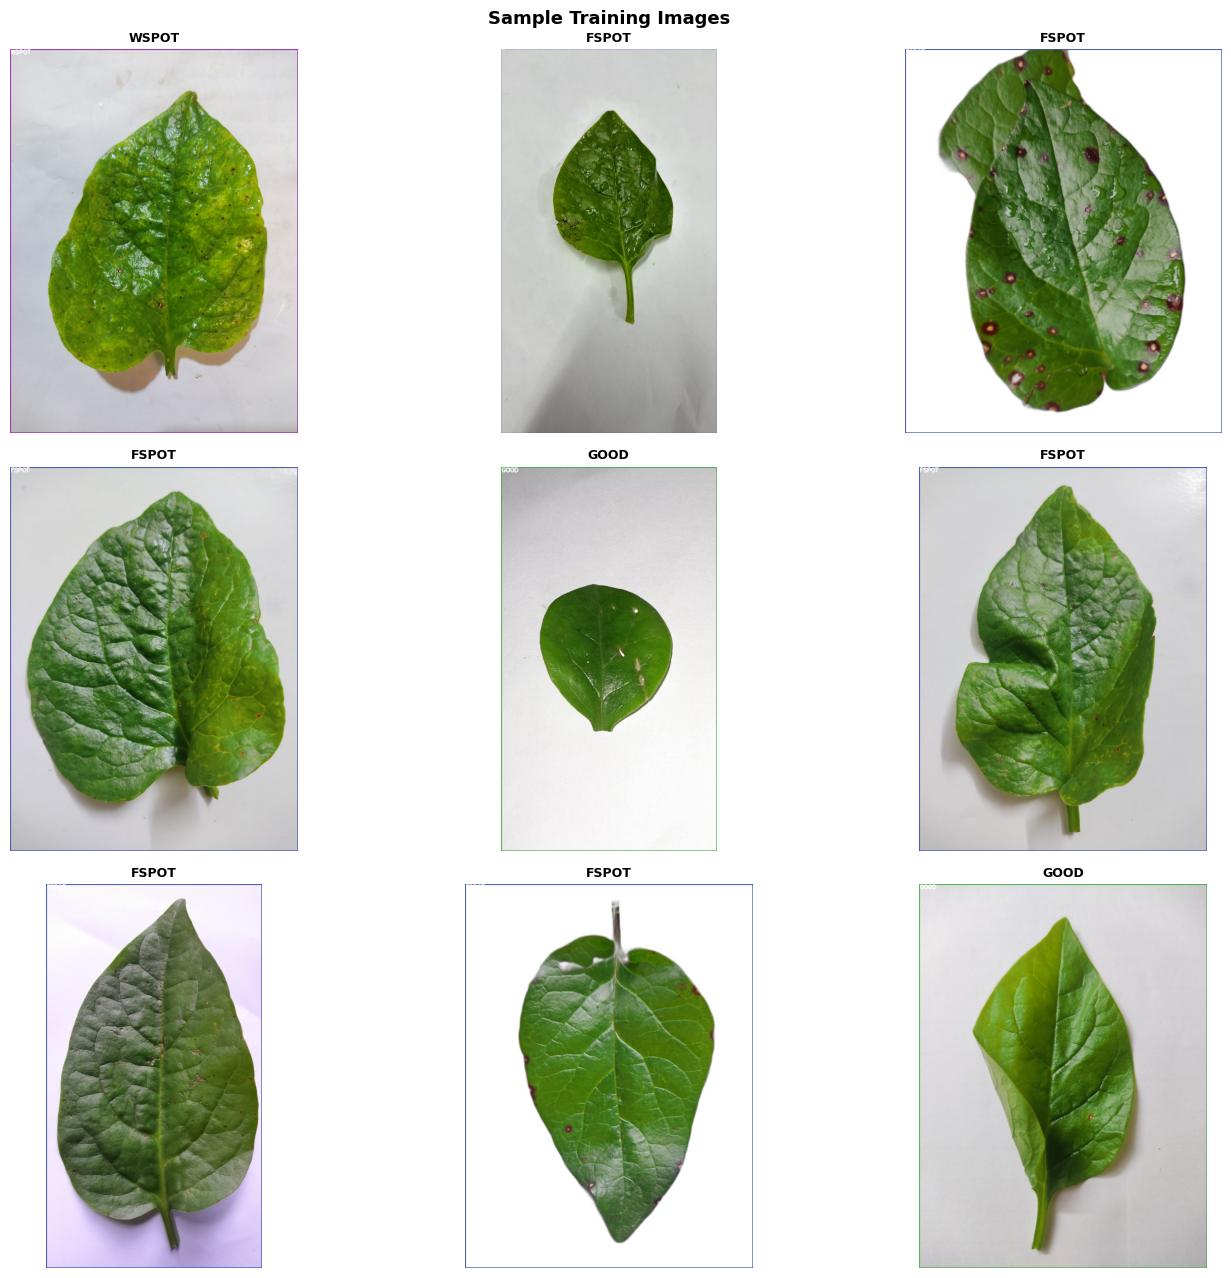

Saved 9 sample images to reports/sample_training_images.png
Boxes should be visible on each image with class names shown above them.
If the box covers the whole image — that is normal for this dataset format.


In [5]:
import cv2
import matplotlib.pyplot as plt
import random

def draw_boxes(img_path, lbl_path):
    img = cv2.imread(str(img_path))
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    if lbl_path.exists():
        for line in lbl_path.read_text().splitlines():
            parts = line.strip().split()
            if len(parts) == 5:
                cls = int(parts[0])
                cx, cy, bw, bh = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
                x1 = int((cx - bw/2) * w)
                y1 = int((cy - bh/2) * h)
                x2 = int((cx + bw/2) * w)
                y2 = int((cy + bh/2) * h)
                col = CLASS_COLORS[cls % len(CLASS_COLORS)]
                cv2.rectangle(img, (x1,y1), (x2,y2), col, 3)
                label = CLASS_NAMES[cls] if cls < len(CLASS_NAMES) else str(cls)
                (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(img, (x1, max(0,y1-22)), (x1+tw+4, y1), col, -1)
                cv2.putText(img, label, (x1+2, max(15, y1-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    return img

train_imgs = list((SPLITS_DIR / 'train' / 'images').glob('*.*'))

if not train_imgs:
    print('No training images found — check that 01_prepare_dataset.py ran successfully.')
else:
    sample = random.sample(train_imgs, min(9, len(train_imgs)))
    fig, axes = plt.subplots(3, 3, figsize=(15, 13))

    for ax, img_path in zip(axes.flatten(), sample):
        lbl_path = SPLITS_DIR / 'train' / 'labels' / (img_path.stem + '.txt')
        img = draw_boxes(img_path, lbl_path)
        if img is not None:
            ax.imshow(img)
            cls_ids = []
            if lbl_path.exists():
                for line in lbl_path.read_text().splitlines():
                    parts = line.strip().split()
                    if parts:
                        cls_ids.append(CLASS_NAMES[int(parts[0])])
            ax.set_title(', '.join(set(cls_ids)) if cls_ids else 'no label', fontsize=9, fontweight='bold')
        ax.axis('off')

    plt.suptitle('Sample Training Images', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'sample_training_images.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f'Saved {len(sample)} sample images to reports/sample_training_images.png')
    print('Boxes should be visible on each image with class names shown above them.')
    print('If the box covers the whole image — that is normal for this dataset format.')

## Cell 5 — Train

This will take around 20–35 minutes on an M2 MacBook Air.
Plug in your charger and leave it running — the best weights are saved automatically to `runs/spinach_v1/weights/best.pt`.
If you need to rerun this cell, just run it again — it overwrites the previous output automatically.
To keep a previous run alongside a new one, change `MODEL_NAME` to `spinach_v2` in Cell 2 first.

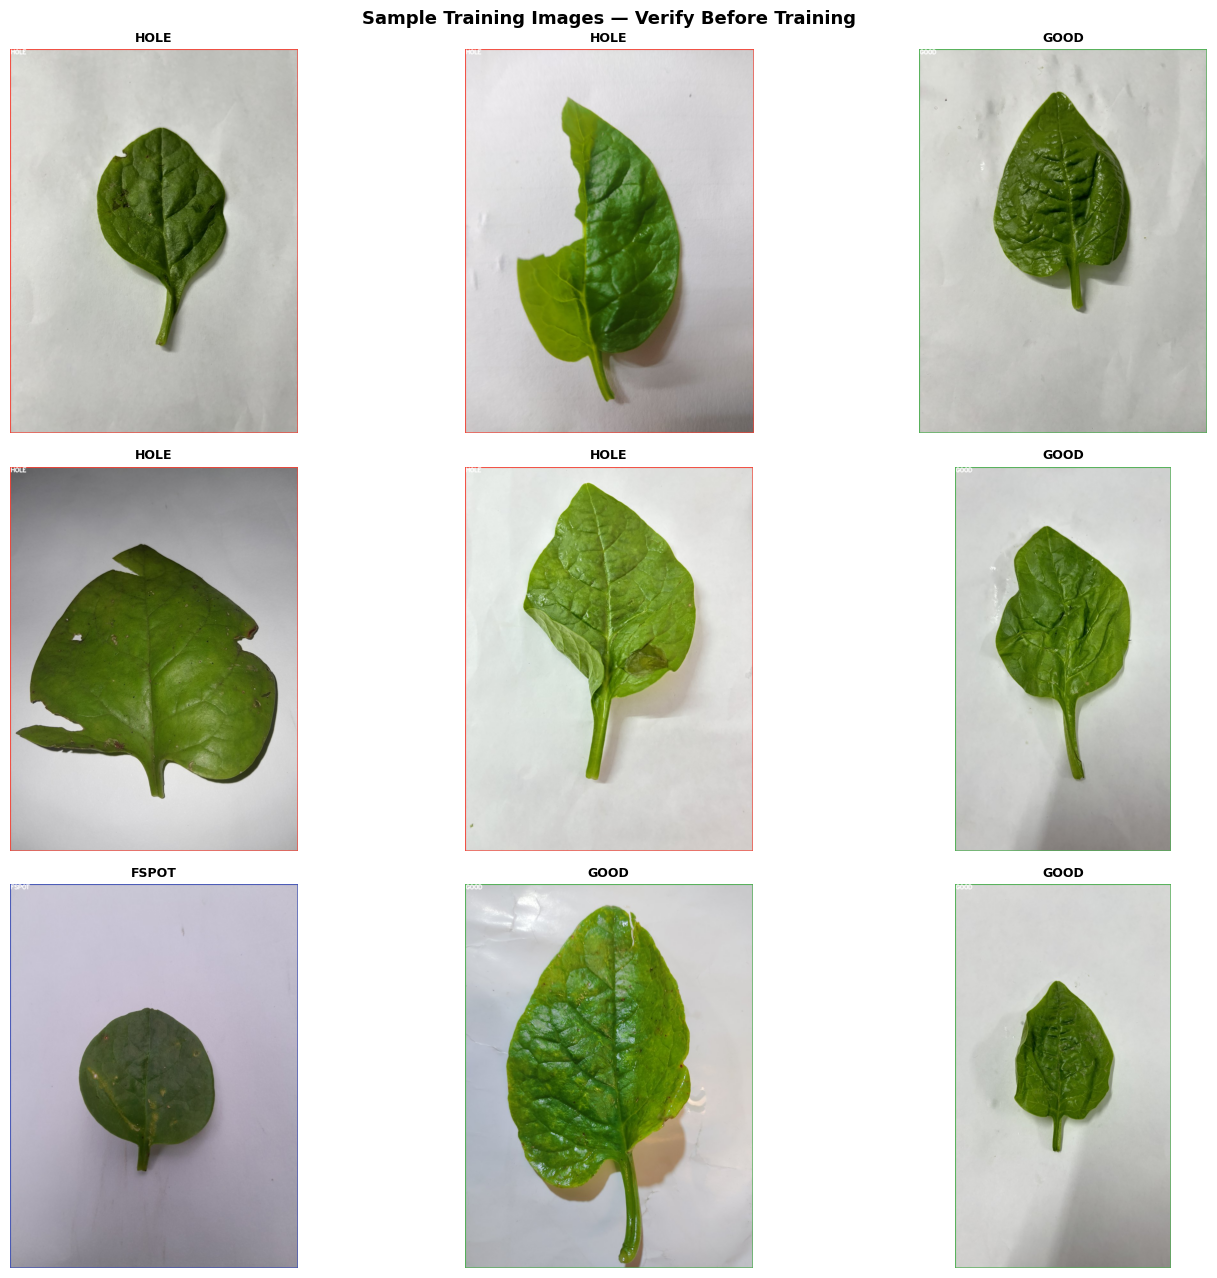

✅ Showing 9 random training images
   Saved to: reports/sample_training_images.png

What to check:
  ✅ Images show spinach/leaves
  ✅ Coloured boxes are drawn on the images
  ✅ Class labels match what you see in the image
  ❌ If boxes cover the entire image — that is expected (classification→detection conversion)
  ❌ If no boxes appear — check your labels folder


In [6]:
import cv2
import matplotlib.pyplot as plt
import random
from pathlib import Path

def draw_boxes(img_path, lbl_path):
    img = cv2.imread(str(img_path))
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    if lbl_path.exists():
        for line in lbl_path.read_text().splitlines():
            parts = line.strip().split()
            if len(parts) == 5:
                cls = int(parts[0])
                cx, cy, bw, bh = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
                x1 = int((cx - bw/2) * w)
                y1 = int((cy - bh/2) * h)
                x2 = int((cx + bw/2) * w)
                y2 = int((cy + bh/2) * h)
                col = CLASS_COLORS[cls % len(CLASS_COLORS)]
                cv2.rectangle(img, (x1,y1), (x2,y2), col, 3)
                label = CLASS_NAMES[cls] if cls < len(CLASS_NAMES) else str(cls)
                # Background rectangle for text readability
                (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
                cv2.rectangle(img, (x1, max(0,y1-22)), (x1+tw+4, y1), col, -1)
                cv2.putText(img, label, (x1+2, max(15, y1-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    return img

train_imgs = list((SPLITS_DIR / 'train' / 'images').glob('*.*'))

if not train_imgs:
    print('❌ No training images found. Run 01_prepare_dataset.py first.')
else:
    sample = random.sample(train_imgs, min(9, len(train_imgs)))
    fig, axes = plt.subplots(3, 3, figsize=(15, 13))

    for ax, img_path in zip(axes.flatten(), sample):
        lbl_path = SPLITS_DIR / 'train' / 'labels' / (img_path.stem + '.txt')
        img = draw_boxes(img_path, lbl_path)
        if img is not None:
            ax.imshow(img)
            # Show class name from label file
            cls_ids = []
            if lbl_path.exists():
                for line in lbl_path.read_text().splitlines():
                    parts = line.strip().split()
                    if parts:
                        cls_ids.append(CLASS_NAMES[int(parts[0])])
            title = ', '.join(set(cls_ids)) if cls_ids else 'no label'
            ax.set_title(title, fontsize=9, fontweight='bold')
        ax.axis('off')

    plt.suptitle('Sample Training Images — Verify Before Training', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'sample_training_images.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f'✅ Showing {len(sample)} random training images')
    print(f'   Saved to: reports/sample_training_images.png')
    print()
    print('What to check:')
    print('  ✅ Images show spinach/leaves')
    print('  ✅ Coloured boxes are drawn on the images')
    print('  ✅ Class labels match what you see in the image')
    print('  ❌ If boxes cover the entire image — that is expected (classification→detection conversion)')
    print('  ❌ If no boxes appear — check your labels folder')

## Cell 6 — Evaluate on Test Set

Runs the trained model against images it has never seen before (the held-out test set).
This gives a fair picture of how well it actually generalises.
Any class showing a warning here is worth looking into — see Cell 9 for options.

In [7]:
from ultralytics import YOLO

print('🚀 Starting training...')
print(f'   Model      : {MODEL_SIZE}')
print(f'   Device     : {DEVICE}')
print(f'   Epochs     : {EPOCHS}')
print(f'   Batch      : {BATCH_SIZE}')
print(f'   Image size : {IMAGE_SIZE}')
print(f'   Early stop : after {PATIENCE} epochs no improvement')
print()

model = YOLO(MODEL_SIZE)   # loads pretrained nano weights from COCO

results = model.train(
    # ── Dataset ──────────────────────────────────────────
    data          = str(DATASET_YAML),
    # ── Hardware ─────────────────────────────────────────
    device        = DEVICE,
    workers       = WORKERS,       # 0 — required on macOS
    amp           = AMP,           # False — required on MPS
    # ── Training ─────────────────────────────────────────
    epochs        = EPOCHS,
    batch         = BATCH_SIZE,
    imgsz         = IMAGE_SIZE,
    patience      = PATIENCE,
    # ── Learning rate ────────────────────────────────────
    lr0           = 0.01,
    lrf           = 0.001,
    warmup_epochs = 3,
    # ── Built-in augmentation ────────────────────────────
    mosaic        = 1.0,
    degrees       = 15.0,
    fliplr        = 0.5,
    flipud        = 0.1,
    hsv_h         = 0.015,
    hsv_s         = 0.7,
    hsv_v         = 0.4,
    # ── Output ───────────────────────────────────────────
    project       = str(RUNS_DIR),
    name          = MODEL_NAME,
    save          = True,
    plots         = True,
    exist_ok      = True,          # overwrites previous run — no need to delete
)

BEST_MODEL = RUNS_DIR / MODEL_NAME / 'weights' / 'best.pt'
print()
print('=' * 50)
print('✅ Training complete!')
print(f'   Best model saved : {BEST_MODEL}')
print('   Next: run Cell 5 to evaluate')
print('=' * 50)

🚀 Starting training...
   Model      : yolov8n.pt
   Device     : mps
   Epochs     : 20
   Batch      : 32
   Image size : 416
   Early stop : after 7 epochs no improvement

Ultralytics 8.4.14 🚀 Python-3.14.2 torch-2.10.0 MPS (Apple M2)
engine/trainer: agnostic_nms=False, amp=False, angle=1.0, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/blackmagic/Data Analyst/Spinach_Project/dataset.yaml, degrees=15.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.1, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.0, mode=tra

KeyboardInterrupt: 

## Cell 7 — Training Curves (Optional)

Plots the loss and mAP over each epoch. Useful for checking if the model trained properly.
Loss should decrease over time and mAP should increase — if they look erratic something went wrong.
The chart is also saved to `reports/training_curves.png`.

In [ ]:
from ultralytics import YOLO

BEST_MODEL = RUNS_DIR / MODEL_NAME / 'weights' / 'best.pt'

if not BEST_MODEL.exists():
    print(f'❌ Model not found. Run Cell 4 first.')
else:
    print(f'Loading: {BEST_MODEL}')
    eval_model = YOLO(str(BEST_MODEL))

    print('\n🔍 Evaluating on test set...')
    metrics = eval_model.val(
        data     = str(DATASET_YAML),
        split    = 'test',
        imgsz    = IMAGE_SIZE,
        conf     = 0.25,
        iou      = 0.5,
        device   = DEVICE,
        workers  = 0,
        plots    = True,
        project  = str(RUNS_DIR),
        name     = MODEL_NAME + '_eval',
        exist_ok = True,
    )

    print()
    print('=' * 50)
    print('📊 TEST SET RESULTS')
    print('=' * 50)
    print(f'  mAP@0.5      : {metrics.box.map50:.4f}   (target ≥ 0.60 for nano)')
    print(f'  mAP@0.5:0.95 : {metrics.box.map:.4f}   (target ≥ 0.40)')
    print(f'  Precision    : {metrics.box.mp:.4f}   (target ≥ 0.70)')
    print(f'  Recall       : {metrics.box.mr:.4f}   (target ≥ 0.65)')
    print('=' * 50)

    print('\n📋 Per-class AP@0.5:')
    print('─' * 45)
    weak = []
    for i, (name, ap) in enumerate(zip(CLASS_NAMES, metrics.box.ap50)):
        flag = '✅' if ap >= 0.50 else '⚠️ '
        print(f'  {flag} [{i}] {name:<15} {ap:.4f}')
        if ap < 0.50:
            weak.append(name)

    print()
    if weak:
        print(f'  ⚠️  Weak classes (AP < 0.50): {", ".join(weak)}')
        print('     → Run Cell 8 (improve) or upgrade to yolov8s in Cell 2')
    else:
        print('  🎉 All classes above 0.50 — good result for nano model!')

Loading: /Users/blackmagic/Data Analyst/Spinach_Project/runs/spinach_v1/weights/best.pt

🔍 Evaluating on test set...
Ultralytics 8.4.14 🚀 Python-3.14.2 torch-2.10.0 MPS (Apple M2)
Model summary (fused): 73 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.1±0.1 ms, read: 441.9±181.2 MB/s, size: 96.9 KB)
val: Scanning /Users/blackmagic/Data Analyst/Spinach_Project/data/splits/test/labels... 456 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 456/456 6.0Kit/s 0.1s
val: New cache created: /Users/blackmagic/Data Analyst/Spinach_Project/data/splits/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 29/29 1.3it/s 21.8s0.3s
                   all        456        456      0.793       0.84       0.86       0.86
                  GOOD        218        218       0.84      0.915      0.941      0.941
                YELLOW          3          3          1          1      0.995   

## Cell 8 — Confusion Matrix (Optional)

Shows which classes the model is getting confused between.
The diagonal should be as dark as possible — that means correct predictions.
If FSPOT and WSPOT are confused with each other for example, you would see it clearly here.
Run Cell 6 first — this reads the output from that evaluation.

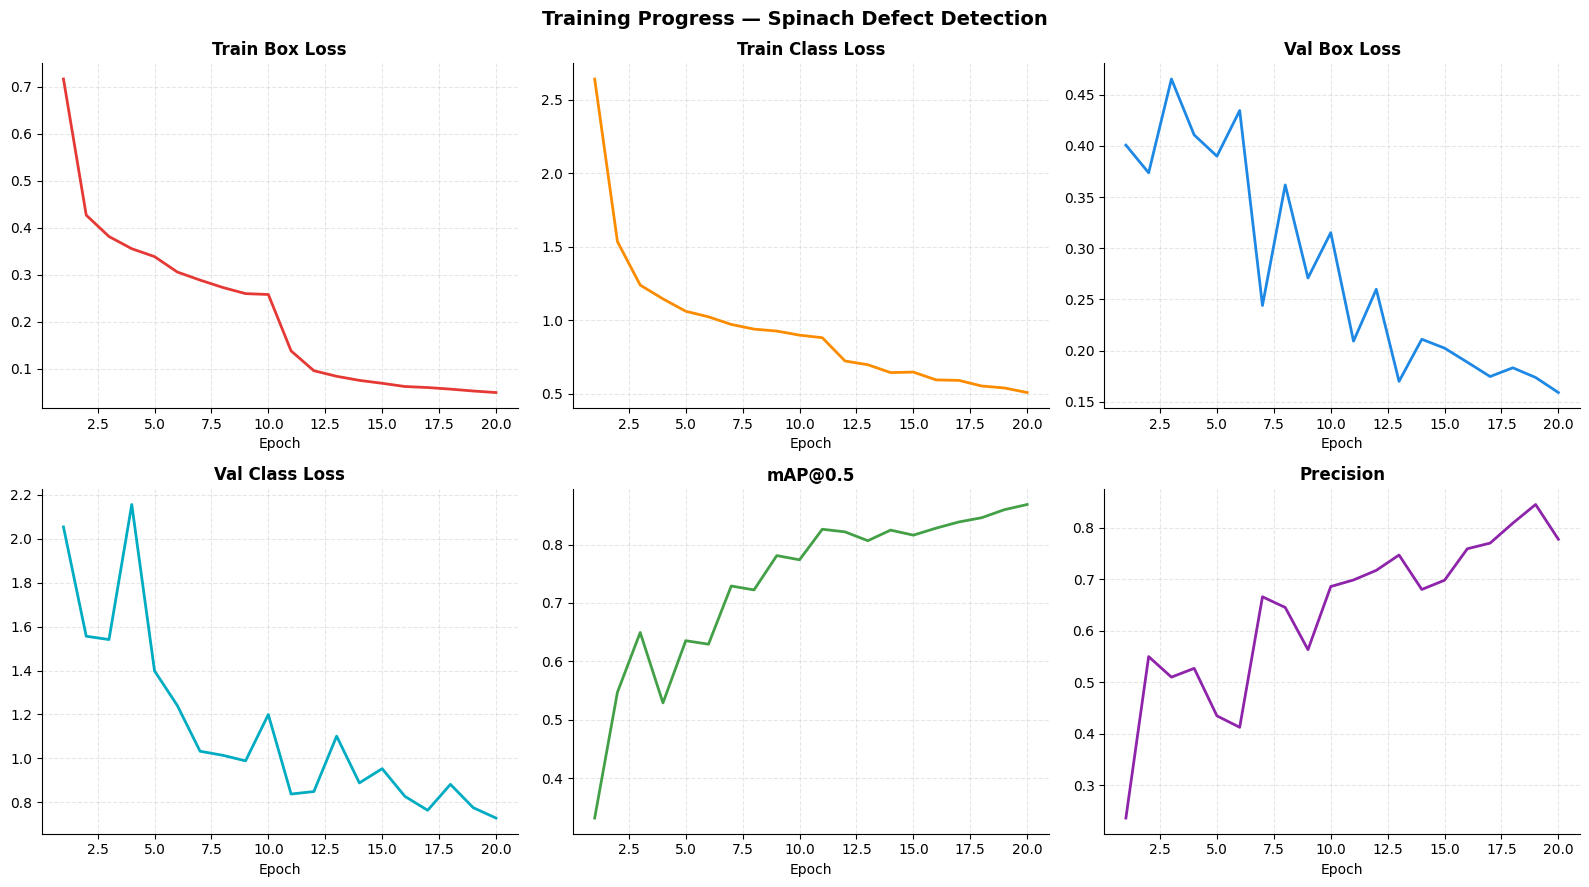

✅ Saved: reports/training_curves.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = RUNS_DIR / MODEL_NAME / 'results.csv'

if not csv_path.exists():
    print('❌ Run Cell 4 first.')
else:
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()

    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    plots = [
        ('train/box_loss',        'Train Box Loss',    '#e53935'),
        ('train/cls_loss',        'Train Class Loss',  '#fb8c00'),
        ('val/box_loss',          'Val Box Loss',      '#1e88e5'),
        ('val/cls_loss',          'Val Class Loss',    '#00acc1'),
        ('metrics/mAP50(B)',      'mAP@0.5',           '#43a047'),
        ('metrics/precision(B)',  'Precision',         '#8e24aa'),
    ]
    for ax, (col, title, colour) in zip(axes.flatten(), plots):
        c = col if col in df.columns else col.replace('(B)','')
        if c in df.columns:
            ax.plot(df['epoch'], df[c], color=colour, linewidth=2)
            ax.set_title(title, fontweight='bold')
            ax.set_xlabel('Epoch')
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        else:
            ax.set_title(f'{title} (not found)', color='grey')
            ax.axis('off')

    plt.suptitle('Training Progress — Spinach Defect Detection', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'training_curves.png', dpi=150)
    plt.show()
    print('✅ Saved: reports/training_curves.png')

## Cell 9 — Test on a New Image (Optional)

Runs the model on a single image and draws the detections.
By default it picks a random image from the test set.
To use your own image, set `USE_TEST_IMAGE = False` and update `MY_IMAGE` with the file path.

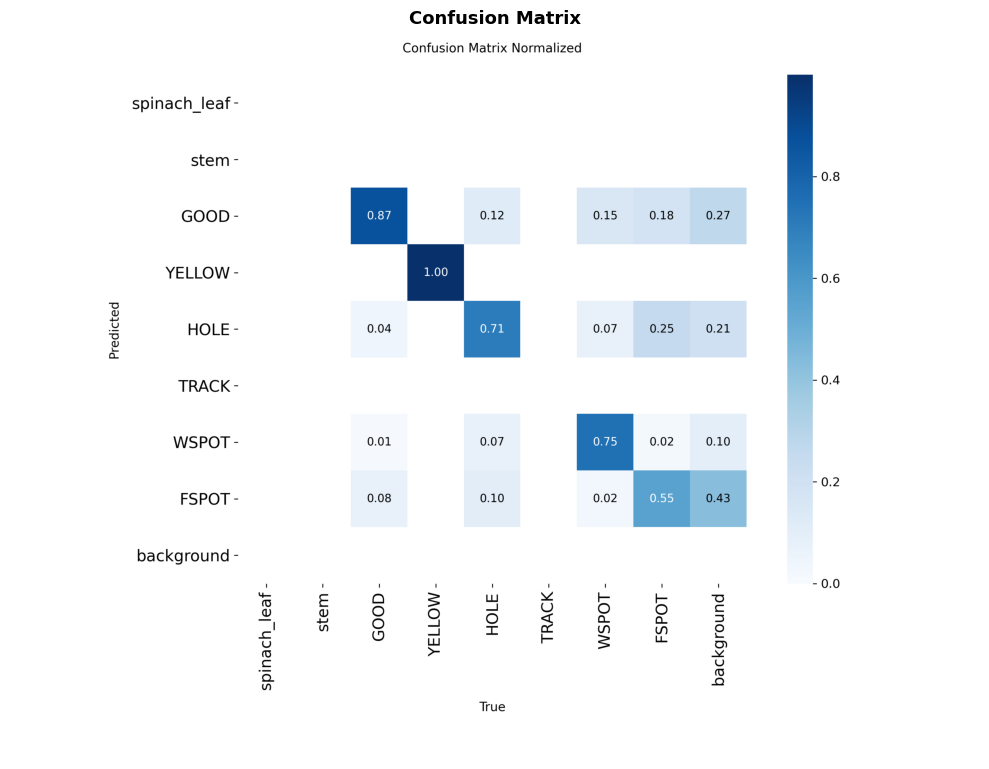

✅ Diagonal = correct predictions (want these high)
   Off-diagonal = misclassifications


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

eval_dir = RUNS_DIR / (MODEL_NAME + '_eval')
for fname in ['confusion_matrix_normalized.png', 'confusion_matrix.png']:
    cm_path = eval_dir / fname
    if cm_path.exists():
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(mpimg.imread(str(cm_path)))
        ax.axis('off')
        ax.set_title('Confusion Matrix', fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.savefig(REPORTS_DIR / 'confusion_matrix.png', dpi=150)
        plt.show()
        print('✅ Diagonal = correct predictions (want these high)')
        print('   Off-diagonal = misclassifications')
        break
else:
    print('❌ Run Cell 5 (evaluate) first.')

## Cell 10 — Upgrade to a Better Model (Optional)

If the results from Cell 6 are not good enough, this switches to `yolov8s` (small) which is more accurate.
It takes around 60–90 minutes but the improvement is usually noticeable.
Change `RUN_UPGRADE` to `True` below and run the cell.

Using: /Users/blackmagic/Data Analyst/Spinach_Project/data/splits/test/images/GOOD_Healthy-Leaf (28).jpg


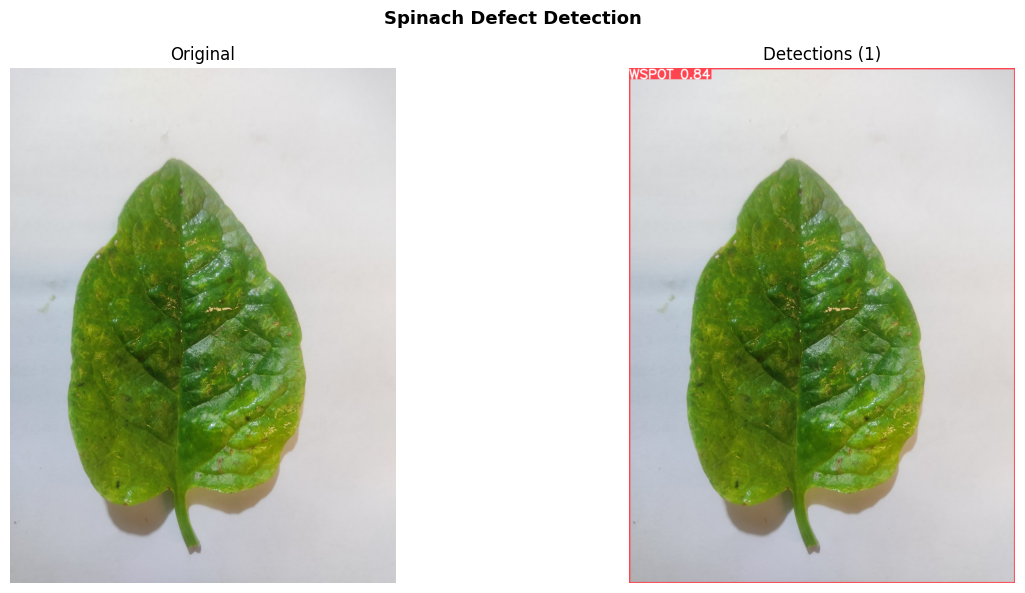


Detected 1 object(s):
  [6] WSPOT           confidence: 83.9%


In [ ]:
import cv2
import matplotlib.pyplot as plt
import random
from ultralytics import YOLO

BEST_MODEL = RUNS_DIR / MODEL_NAME / 'weights' / 'best.pt'

# ── Change this to your own image path, or leave USE_TEST_IMAGE = True ──
MY_IMAGE       = 'path/to/your/spinach.jpg'
USE_TEST_IMAGE = True   # uses a random image from your test set
# ────────────────────────────────────────────────────────────────────────

if not BEST_MODEL.exists():
    print('❌ Run Cell 4 first.')
else:
    infer_model = YOLO(str(BEST_MODEL))
    if USE_TEST_IMAGE:
        test_imgs = list((SPLITS_DIR / 'test' / 'images').glob('*.*'))
        source = str(random.choice(test_imgs))
        print(f'Using: {source}')
    else:
        source = MY_IMAGE

    results = infer_model.predict(
        source  = source,
        conf    = 0.30,
        imgsz   = IMAGE_SIZE,
        device  = DEVICE,
        verbose = False,
    )

    for result in results:
        ann = cv2.cvtColor(result.plot(), cv2.COLOR_BGR2RGB)
        orig = cv2.cvtColor(cv2.imread(result.path), cv2.COLOR_BGR2RGB)

        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].imshow(orig);  axes[0].set_title('Original');    axes[0].axis('off')
        axes[1].imshow(ann);   axes[1].set_title(f'Detections ({len(result.boxes)})'); axes[1].axis('off')
        plt.suptitle('Spinach Defect Detection', fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()

        print(f'\nDetected {len(result.boxes)} object(s):')
        for box in result.boxes:
            cls_id = int(box.cls[0])
            print(f'  [{cls_id}] {CLASS_NAMES[cls_id]:<15} confidence: {float(box.conf[0]):.1%}')

## Cell 11 — Export (Optional)

Exports the trained model to ONNX format so it can be used on any machine.
The `.pt` file is PyTorch-only — the ONNX file works anywhere without needing PyTorch installed.

In [ ]:
# RUN_UPGRADE = False   # set True to run upgraded model

# if RUN_UPGRADE:
#     from ultralytics import YOLO

#     model_v2 = YOLO('yolov8s.pt')   # small — more accurate than nano
#     model_v2.train(
#         data          = str(DATASET_YAML),
#         device        = DEVICE,
#         workers       = 0,
#         amp           = False,
#         epochs        = 30,
#         batch         = 16,          # batch 16 for small model on M2 Air
#         imgsz         = 640,         # back to 640 for better accuracy
#         patience      = 10,
#         lr0           = 0.01,
#         lrf           = 0.001,
#         warmup_epochs = 3,
#         mosaic        = 1.0,
#         degrees       = 15.0,
#         fliplr        = 0.5,
#         flipud        = 0.1,
#         hsv_s         = 0.7,
#         hsv_v         = 0.4,
#         project       = str(RUNS_DIR),
#         name          = 'spinach_v2_small',
#         save          = True,
#         plots         = True,
#         exist_ok      = True,
#     )
#     print('\n✅ Upgraded model done! Evaluate with Cell 5 — change MODEL_NAME to spinach_v2_small')

: 

## Cell 11 — Export Model (Optional)

In [ ]:
from ultralytics import YOLO

BEST_MODEL = RUNS_DIR / MODEL_NAME / 'weights' / 'best.pt'

if not BEST_MODEL.exists():
    print('❌ Run Cell 4 first.')
else:
    m = YOLO(str(BEST_MODEL))
    path = m.export(format='onnx', imgsz=IMAGE_SIZE)
    print(f'✅ Exported: {path}')
    print('\nTo use this model anywhere:')
    print(f'  model = YOLO("{BEST_MODEL}")')
    print('  results = model.predict("spinach.jpg", conf=0.3)')

NameError: name 'RUNS_DIR' is not defined